In [206]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib import rc,cm,colorbar
import glob,os
from scipy.interpolate import griddata
from linecache import getline as gl
import calendar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv
import statistics
from bisect import bisect_left

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 15}
rc('font', **font)

In [2]:
os.chdir("/scratch/p/peltier/huoyilin/CanadaLakeData/GLSEA")
# Read latitude/longitude data
q=nc.Dataset('1995_001_glsea_sst.nc','r',format='NETCDF4')
lat = q.variables['lat']
lon = q.variables['lon']
ncols=len(lat);nrows=len(lon)
year1=1995;year2=2018
nyear=year2-year1+1;nmonth=12*nyear
Tsk_o=np.zeros((int(ncols),int(nrows),nmonth))
Tsk_12month_o=np.zeros((int(ncols),int(nrows),12))
daymonthrange=np.zeros((13))
for iyear in range (year1,year2+1):
    for imonth in range (1,13):
        daymonthrange[imonth]=daymonthrange[imonth-1]+calendar.monthrange(iyear,imonth)[1]
        for iday in range (int(daymonthrange[imonth-1]),int(daymonthrange[imonth])):
            q=nc.Dataset(str(iyear)+'_'+"%03d" % (iday+1)+'_glsea_sst.nc','r',format='NETCDF4')
            data= q.variables['sst'][0]
            data[data<-300]=np.nan
            Tsk_o[:,:,(iyear-year1)*12+imonth-1]+=data
        Tsk_o[:,:,(iyear-year1)*12+imonth-1]/=daymonthrange[imonth]-daymonthrange[imonth-1]
for imonth in range (0,12):
    Tsk_12month_o[:,:,imonth]=np.mean(Tsk_o[:,:,imonth:12*iyear:12],axis=2)

In [213]:
model='14'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfout/wrfconst_d01.nc','r',format='NETCDF4')
wrf_land=q.variables['LAKEMASK'][0]
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfout/wrfconst_d01.nc','r',format='NETCDF4')
wrf_lat=q.variables['XLAT'][0]
wrf_lon=q.variables['XLONG'][0]
nlat=len(wrf_lat);nlon=len(wrf_lat[0])

q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_monthly.nc','r',format='NETCDF4')
LakeTsk= q.variables['TSK'][:]-273.15#for DM
#q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
#LakeTsk=q.variables['ALBEDO'][:]
ntim=len(LakeTsk)
Tsk_tmp=np.zeros((nlat,nlon,12))
for imonth in range (0,12):
    Tsk_tmp[:,:,imonth]=np.mean(LakeTsk[imonth+(year1-1979)*12:ntim:12,:,:],axis=0)
Tsk_d=Tsk_tmp
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
LakeIce= q.variables['IceFrac_A60']#for DM
Tsk_tmp=np.zeros((nlat,nlon,12))
for imonth in range (0,12):
    Tsk_tmp[:,:,imonth]=np.mean(LakeIce[imonth+(year1-1979)*12:ntim:12,:,:],axis=0)
Ice_d=Tsk_tmp
Ice_d[Ice_d<=0]=np.nan
Ice_d[~np.isnan(Ice_d)]=1

##for GL25
model='13'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_monthly.nc','r',format='NETCDF4')
LakeTsk= q.variables['TSK'][:]-273.15
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
tmp= q.variables['T_LAKE3D'][:]-273.15
tmp[tmp<-300]=np.nan
#q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfrad_d01_monthly.nc','r',format='NETCDF4')
#LakeTsk=q.variables['ACSWUPB'][:]/q.variables['ACSWDNB'][:]
ntim=len(tmp);nlat=len(tmp[0][0]);nlon=len(tmp[0][0][0])
LakeTsk = tmp[:,0]
for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        for itim in range(0,ntim):
            index = min(24,bisect_left(tmp[itim,:,ilat,ilon],0))
            LakeTsk[itim,ilat,ilon]=tmp[itim,index,ilat,ilon]
Tsk_tmp=np.zeros((nlat,nlon,12))
for imonth in range (0,12):
    Tsk_tmp[:,:,imonth]=np.mean(LakeTsk[imonth+(year1-1979)*12:ntim:12,:,:],axis=0)
Tsk_g=Tsk_tmp
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
LakeIce = q.variables['LAKE_ICEFRAC3D'][:,0,:,:] #top layer ice
LakeIce[LakeIce < 0] = 0
Tsk_tmp=np.zeros((nlat,nlon,12))
for imonth in range (0,12):
    Tsk_tmp[:,:,imonth]=np.mean(LakeIce[imonth+(year1-1979)*12:ntim:12,:,:],axis=0)
Ice_g=Tsk_tmp
Ice_g[Ice_g<=0]=np.nan
Ice_g[~np.isnan(Ice_g)]=1
##for FLake
model='78g'
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_monthly.nc','r',format='NETCDF4')
LakeTsk= q.variables['T_WML_LAKE'][:]-273.15
LakeTsk[LakeTsk<-273]=np.nan
#LakeTsk= q.variables['TSK'][:]
#q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrflsm_d01_monthly.nc','r',format='NETCDF4')
#LakeTsk=q.variables['ALBEDO'][:]
ntim=len(LakeTsk)
Tsk_tmp=np.zeros((nlat,nlon,12))
for imonth in range (0,12):
    Tsk_tmp[:,:,imonth]=np.mean(LakeTsk[imonth+(year1-1979)*12:ntim:12,:,:],axis=0)
Tsk_f=Tsk_tmp
q=nc.Dataset('/scratch/p/peltier/mahdinia/ERAI_AND_ERA5_RUN_CASES/WRFTools_RC'+model+'/wrfavg_SMALL/wrfsrfc_d01_monthly.nc','r',format='NETCDF4')
LakeIce=q.variables['IceFrac_H0.001']
Tsk_tmp=np.zeros((nlat,nlon,12))
for imonth in range (0,12):
    Tsk_tmp[:,:,imonth]=np.mean(LakeIce[imonth+(year1-1979)*12:ntim:12,:,:],axis=0)
Ice_f=Tsk_tmp
Ice_f[Ice_f<=0]=np.nan
Ice_f[~np.isnan(Ice_f)]=1

In [223]:
Tsk_d_z=Tsk_12month_o*0
Tsk_g_z=Tsk_12month_o*0
Tsk_f_z=Tsk_12month_o*0
xv, yv = np.meshgrid(lon, lat)
for imonth in range(0,12):
    Tsk_d_z[:,:,imonth] = griddata((wrf_lon.flatten(),wrf_lat.flatten()), Tsk_d[:,:,imonth].flatten(), (xv, yv))
    Tsk_g_z[:,:,imonth] = griddata((wrf_lon.flatten(),wrf_lat.flatten()), Tsk_g[:,:,imonth].flatten(), (xv, yv))
    Tsk_f_z[:,:,imonth] = griddata((wrf_lon.flatten(),wrf_lat.flatten()), Tsk_f[:,:,imonth].flatten(), (xv, yv))
Tsk_d_z-=Tsk_12month_o
Tsk_g_z-=Tsk_12month_o
Tsk_f_z-=Tsk_12month_o


<ipython-input-226-9adad14645a1>:12: RuntimeWarning: Mean of empty slice
  im=ax1.pcolor(lon, lat, np.nanmean(Tsk_12month_o[:,:,month1:month2],2), cmap='jet',vmin=0, vmax=4)
<ipython-input-226-9adad14645a1>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax1.pcolor(lon, lat, np.nanmean(Tsk_12month_o[:,:,month1:month2],2), cmap='jet',vmin=0, vmax=4)
<ipython-input-226-9adad14645a1>:31: RuntimeWarning: Mean of empty slice
  im=ax1.pcolor(lon, lat,np.nanmean(Tsk_g_z[:,:,month1:month2],2), cmap='seismic',vmin=v1, vmax=v2)
<ipython-input-226-9adad14645a1>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals wi

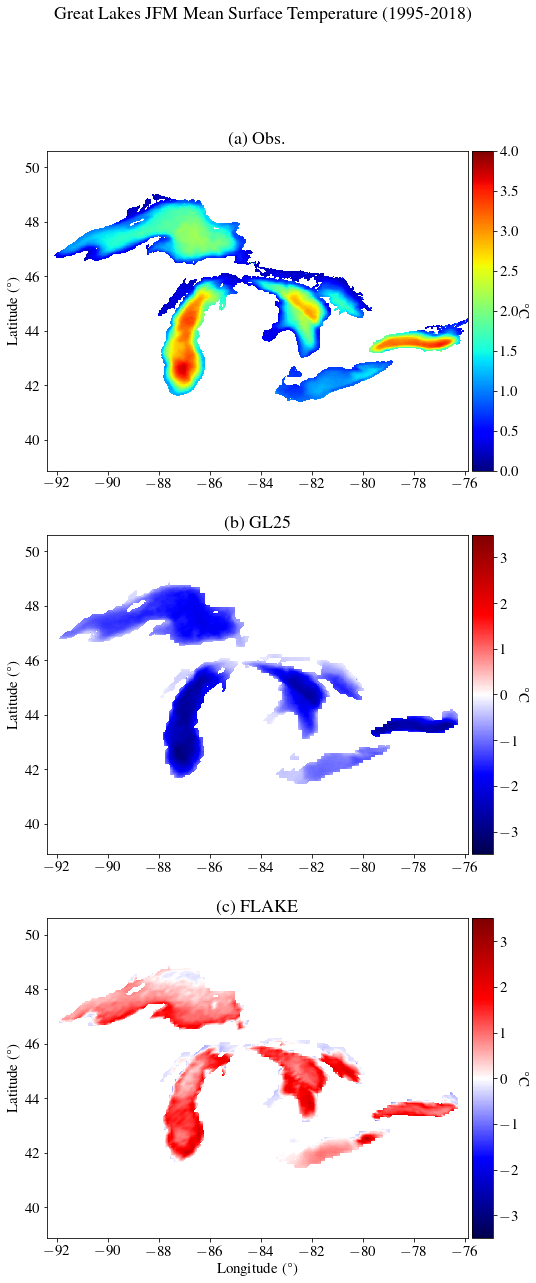

In [226]:
wrf_land[wrf_land<=0]=np.nan
v1=-3.5;v2=-v1
#v1=0.065;v2=.125
#hgt_w=q.variables['HGT'][0]
month1=0;month2=3
lon1=np.min(lon);lon2=np.max(lon);lat1=np.min(lat);lat2=np.max(lat)
#lon1=-126;lon2=-107;lat1=58;lat2=68
#lon1=-102;lon2=-96;lat1=50;lat2=55
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 20))
ax1= axes.flat[0];
ax1.title.set_text('(a) Obs.')
im=ax1.pcolor(lon, lat, np.nanmean(Tsk_12month_o[:,:,month1:month2],2), cmap='jet',vmin=0, vmax=4)
ax1.set_ylabel('Latitude (\N{DEGREE SIGN})')
#cbar = fig.colorbar(im, cax=ax1,ax=axes.ravel().tolist())#, orientation = 'horizontal'
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('\N{DEGREE SIGN}C', rotation=-90,labelpad=10)
ax1= axes.flat[1];
# ax1.title.set_text('(b) DM')
# im=ax1.pcolor(wrf_lon, wrf_lat, np.nanmean(Tsk_d[:,:,month1:month2],2)*wrf_land, cmap='jet',vmin=v1, vmax=v2)
# #im=ax1.pcolor(wrf_lon, wrf_lat, np.nanmean(Tsk_d[:,:,month1:month2],2)*wrf_land, cmap='RdYlBu_r',vmin=v1, vmax=v2)
# im=ax1.pcolor(lon, lat,np.nanmean(Tsk_d_z[:,:,month1:month2],2), cmap='seismic',vmin=v1, vmax=v2)
# # #ax1.contour(wrf_lon, wrf_lat, hgt_w, levels=[500],colors='k')
# ax1.set_ylim([lat1,lat2]);ax1.set_xlim([lon1,lon2])
# ax1= axes.flat[2];
ax1.title.set_text('(b) GL25')
#ax1.pcolor(wrf_lon, wrf_lat, hgt_w, cmap='terrain')
#ax1.pcolor(wrf_lon, wrf_lat, np.nanmean(Tsk_g[:,:,month1:month2],2)*wrf_land, cmap='jet',vmin=v1, vmax=v2)
#im=ax1.pcolor(wrf_lon, wrf_lat, np.nanmean(Tsk_g[:,:,month1:month2],2)*wrf_land, cmap='RdYlBu_r',vmin=v1, vmax=v2)
im=ax1.pcolor(lon, lat,np.nanmean(Tsk_g_z[:,:,month1:month2],2), cmap='seismic',vmin=v1, vmax=v2)
ax1.set_ylim([lat1,lat2]);ax1.set_xlim([lon1,lon2])
#ax1.set_xlabel('Longitude (\N{DEGREE SIGN})')
ax1.set_ylabel('Latitude (\N{DEGREE SIGN})')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('\N{DEGREE SIGN}C', rotation=-90,labelpad=10)
ax1= axes.flat[2];
ax1.title.set_text('(c) FLAKE')
ax1.set_ylim([lat1,lat2]);ax1.set_xlim([lon1,lon2])
#im=ax1.pcolor(wrf_lon, wrf_lat, np.nanmean(Tsk_f[:,:,month1:month2],2)*wrf_land, cmap='jet',vmin=v1, vmax=v2)
#im=ax1.pcolor(wrf_lon, wrf_lat, np.nanmean(Tsk_f[:,:,month1:month2],2)*wrf_land, cmap='RdYlBu_r',vmin=v1, vmax=v2)
im=ax1.pcolor(lon, lat,np.nanmean(Tsk_f_z[:,:,month1:month2],2), cmap='seismic',vmin=v1, vmax=v2)
#ax1.contour(wrf_lon, wrf_lat, hgt_w, colors='k')
ax1.set_xlabel('Longitude (\N{DEGREE SIGN})')
ax1.set_ylabel('Latitude (\N{DEGREE SIGN})')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('\N{DEGREE SIGN}C', rotation=-90,labelpad=10)

# cbar = fig.colorbar(im, ax=axes.ravel().tolist())#, orientation = 'horizontal'
# cbar.set_label('\N{DEGREE SIGN}C', rotation=-90)
plt.suptitle('Great Lakes JFM Mean Surface Temperature (1995-2018)') 
fig.patch.set_facecolor('xkcd:white')
plt.show() 

In [235]:
np.nanmean(Tsk_d_z[:,:,5:8])

2.5687811031781607

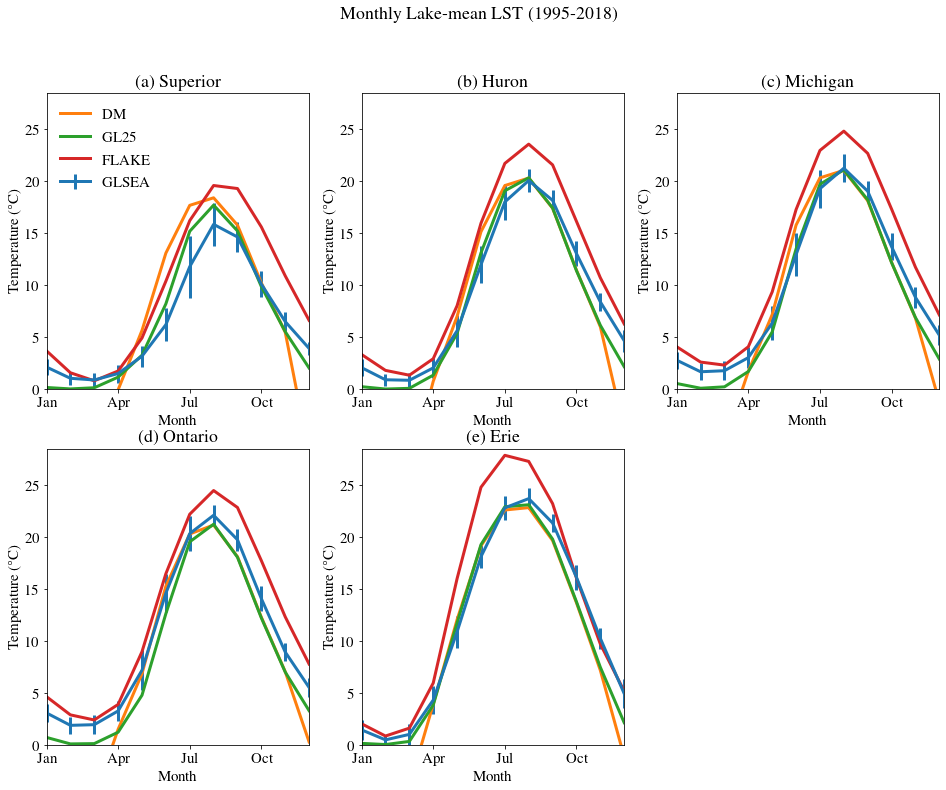

In [230]:
#lake averages
letters=['a','b','c','d','e','f','g']
lake_list=['Superior','Huron','Michigan','Ontario', 'Erie']
nlake=len(lake_list)
Tsk_monthly=np.zeros( (12*nyear,nlake))
Tsk_month_o=np.zeros( (12,nlake*2))
Tsk_month_g=np.zeros( (12,nlake))
Tsk_month_d=np.zeros( (12,nlake))
Tsk_month_f=np.zeros( (12,nlake))
fig = plt.figure()
fig.set_size_inches(16, 12)
for lakeid in range(0, nlake):
    rows = []
    with open('/scratch/p/peltier/huoyilin/CanadaLakeData/GLSEA/all_year_glsea_avg_'+lake_list[lakeid][0].lower()+'_C.csv', 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        for row in csvreader:
            rows.append(row)
    rows=np.array(rows)
    rows1=np.zeros((366,nyear))+np.nan
    for i in range (1,nyear+1):
        for j in range (0,len(rows)):
            if rows[j,i]:
                rows1[j,i-1]=float(rows[j,i])
    for iyear in range (0, nyear):
        for imonth in range (0,12):
            daymonthrange[imonth+1]=daymonthrange[imonth]+calendar.monthrange(iyear+year1,imonth+1)[1]
            Tsk_monthly[imonth+12*iyear,lakeid]=np.mean(rows1[int(daymonthrange[imonth]):int(daymonthrange[imonth+1]),iyear],axis=0)
#    df = pd.read_csv()
    q=nc.Dataset('/project/p/peltier/huoyilin/wmo_basins_shp/'+lake_list[lakeid]+'_mask.nc','r',format='NETCDF4')
    wrf_lake=q.variables['mask_array'][:].astype(np.float)
    wrf_lake[wrf_lake<=0]=np.nan
    for imonth in range (0,12):
        Tsk_month_o[imonth,lakeid]=np.mean(Tsk_monthly[imonth:12*nyear:12,lakeid])
        Tsk_month_o[imonth,lakeid+nlake]=statistics.stdev(Tsk_monthly[imonth:12*nyear:12,lakeid].flatten())
        Tsk_month_d[imonth,lakeid]=np.nanmean(Tsk_d[:,:,imonth]*wrf_lake*wrf_land)
        Tsk_month_g[imonth,lakeid]=np.nanmean(Tsk_g[:,:,imonth]*wrf_lake*wrf_land)
        Tsk_month_f[imonth,lakeid]=np.nanmean(Tsk_f[:,:,imonth]*wrf_lake*wrf_land)
    #Tsk_month_d[0:3,lakeid]=np.nan
    ax1 = fig.add_subplot(2,3,lakeid+1)
    ax1.title.set_text('('+letters[lakeid]+') '+lake_list[lakeid])
    plt.errorbar(x=range(1,13),y=Tsk_month_o[:,lakeid], yerr=Tsk_month_o[:,lakeid+nlake], linewidth=3, label = 'GLSEA')
    plt.plot(range(1,13),Tsk_month_d[:,lakeid], linewidth=3, label = 'DM') 
    plt.plot(range(1,13),Tsk_month_g[:,lakeid], linewidth=3, label = 'GL25') 
    plt.plot(range(1,13),Tsk_month_f[:,lakeid], linewidth=3, label = 'FLAKE') 
    plt.ylabel('Temperature (\N{DEGREE SIGN}C)')
    plt.xlabel('Month')
    plt.setp(ax1, xticks=[1, 4, 7,10], xticklabels=['Jan', 'Apr', 'Jul','Oct'])
    plt.axis([1, 12,0 ,28.5])
    if lakeid==0:
        plt.legend(frameon=False)
plt.suptitle('Monthly Lake-mean LST (1995-2018)')
fig.patch.set_facecolor('xkcd:white')
plt.show()